# Plot census data using geopandas

In [1]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame

import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union
import h3
import base64
import urllib
import tempfile

import matplotlib.pyplot as plt

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
gpd.__version__

'0.10.2'

In [3]:
zip_f = "nyc/tl_2020_36_tract.zip"

In [4]:
census_geo = gpd.read_file(zip_f)

In [5]:
census_geo.head(3)

STATEFP COUNTYFP TRACTCE        GEOID NAME         NAMELSAD  MTFCC FUNCSTAT  \
0      36      047  000700  36047000700    7   Census Tract 7  G5020        S   
1      36      047  000900  36047000900    9   Census Tract 9  G5020        S   
2      36      047  001100  36047001100   11  Census Tract 11  G5020        S   

    ALAND  AWATER     INTPTLAT      INTPTLON  \
0  176774       0  +40.6923505  -073.9973434   
1  163469       0  +40.6917206  -073.9916018   
2  168507       0  +40.6932903  -073.9877087   

                                            geometry  
0  POLYGON ((-74.00154 40.69279, -74.00132 40.693...  
1  POLYGON ((-73.99405 40.69090, -73.99374 40.691...  
2  POLYGON ((-73.99073 40.69305, -73.99045 40.693...

In [6]:
census_geo.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [7]:
commute = pd.read_csv('nyc/ny_commute_census_tract.csv')
commute = commute.drop(0,axis=0)

In [8]:
commute = commute.rename(columns={"FIPS": "GEOID"})

In [9]:
combined = census_geo.merge(commute, on='GEOID')

In [10]:
combined.head(3)

STATEFP COUNTYFP TRACTCE        GEOID NAME         NAMELSAD  MTFCC FUNCSTAT  \
0      36      047  000700  36047000700    7   Census Tract 7  G5020        S   
1      36      047  000900  36047000900    9   Census Tract 9  G5020        S   
2      36      047  001100  36047001100   11  Census Tract 11  G5020        S   

    ALAND  AWATER  ... Workers 16 Years and Over: Did Not Work At Home  \
0  176774       0  ...                                            1884   
1  163469       0  ...                                            2627   
2  168507       0  ...                                            1039   

  Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes  \
0                                                132                      
1                                                181                      
2                                                 30                      

  Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes  \
0                                                165                  
1                                                565                  
2                                                222                  

  Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes  \
0                                                316                  
1                                                494                  
2                                                191                  

  Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes  \
0                                                632                  
1                                                751                  
2                                                297                  

  Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes  \
0                                                481                  
1                                                545                  
2                                                196                  

  Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes  \
0                                                 39                  
1                                                 25                  
2                                                 47                  

  Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes  \
0                                                119                    
1                                                 66                    
2                                                 56                    

  Workers 16 Years and Over: Worked At Home.1 Average Commute to Work (In Min)  
0                                         303                               36  
1                                         613                               29  
2                                         151                               32  

[3 rows x 88 columns]

In [11]:
combined.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'Qualifying Name', 'File identification', 'State Postal Abbreviation',
       'Summary Level', 'Geographic Component', 'Logical Record Number', 'US',
       'Census Region', 'Census Division', 'State (Census Code)',
       'State (FIPS Code)', 'County of current residence',
       'County Subdivision (FIPS)', 'Place (FIPS Code)', 'Census Tract',
       'Block Group', 'Consolidated City',
       'American Indian Area/Alaska Native Area/ Hawaiian Home Land (Census)',
       'American Indian Area/Alaska Native Area/ Hawaiian Home Land (FIPS)',
       'American Indian Trust Land/Hawaiian Home Land Indicator',
       'American Indian Tribal Subdivision (Census)',
       'American Indian Tribal Subdivision (FIPS)',
       'Alaska Native Regional Corporation (FIPS)',
       'Metropolitan and Micropolitan Statistical Area',
       'Comb

In [12]:
combined = combined.to_crs("EPSG:4326")
combined.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Noise complaints

In [13]:
#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis', basemap=None, ax=None):  
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df.plot.scatter(ax=ax, x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    if basemap:
        ctx.add_basemap(ax=ax, crs=basemap)

    plt.xticks([], []); plt.yticks([], [])
    return ax
    

In [14]:
#Declare the directory path for the GTFS zip file
path = 'nyc/gtfs.zip'

#Read the feed with gtfs-kit
feed = (gk.read_feed(path, dist_units='km'))

In [15]:
#Search for errors and warnings in the feed
feed.validate()

type                 message  table  \
0  warning  Stop has no stop times  stops   

                                       rows  
0  [112, 113, 1046, 1087, 1088, 1294, 1295]

In [16]:
feed.describe()

indicator                        value
0                           agencies  [MTA New York City Transit]
1                           timezone             America/New_York
2                         start_date                     20211219
3                           end_date                     20220625
4                         num_routes                           30
5                          num_trips                        68000
6                          num_stops                         1497
7                         num_shapes                          224
8                        sample_date                     20211223
9   num_routes_active_on_sample_date                           29
10   num_trips_active_on_sample_date                         8322
11   num_stops_active_on_sample_date                          991

In [17]:
stops = feed.get_stops()
stops_geo = gpd.GeoDataFrame(
    stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat))

stops_geo = stops_geo.set_crs('EPSG:4326')

clean_stops_geo = stops_geo[(~stops_geo['geometry'].is_empty)&
                                      (~stops_geo['geometry'].isna())]

In [18]:
clean_stops_geo

stop_id                  stop_name   stop_lat   stop_lon  location_type  \
0        101  Van Cortlandt Park-242 St  40.889248 -73.898583            1.0   
1       101N  Van Cortlandt Park-242 St  40.889248 -73.898583            NaN   
2       101S  Van Cortlandt Park-242 St  40.889248 -73.898583            NaN   
3        103                     238 St  40.884667 -73.900870            1.0   
4       103N                     238 St  40.884667 -73.900870            NaN   
...      ...                        ...        ...        ...            ...   
1492    S30N              Tompkinsville  40.636949 -74.074835            NaN   
1493    S30S              Tompkinsville  40.636949 -74.074835            NaN   
1494     S31                  St George  40.643748 -74.073643            1.0   
1495    S31N                  St George  40.643748 -74.073643            NaN   
1496    S31S                  St George  40.643748 -74.073643            NaN   

     parent_station                    geometry  
0               NaN  POINT (-73.89858 40.88925)  
1               101  POINT (-73.89858 40.88925)  
2               101  POINT (-73.89858 40.88925)  
3               NaN  POINT (-73.90087 40.88467)  
4               103  POINT (-73.90087 40.88467)  
...             ...                         ...  
1492            S30  POINT (-74.07483 40.63695)  
1493            S30  POINT (-74.07483 40.63695)  
1494            NaN  POINT (-74.07364 40.64375)  
1495            S31  POINT (-74.07364 40.64375)  
1496            S31  POINT (-74.07364 40.64375)  

[1497 rows x 7 columns]

In [19]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
stops[hex_col] = stops.apply(lambda x: h3.geo_to_h3(x.stop_lat,x.stop_lon,APERTURE_SIZE),1)

# aggregate the points
stopsg = stops.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
stopsg['stop_lat'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
stopsg['stop_lon'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

Text(0.5, 1.0, 'Subway')

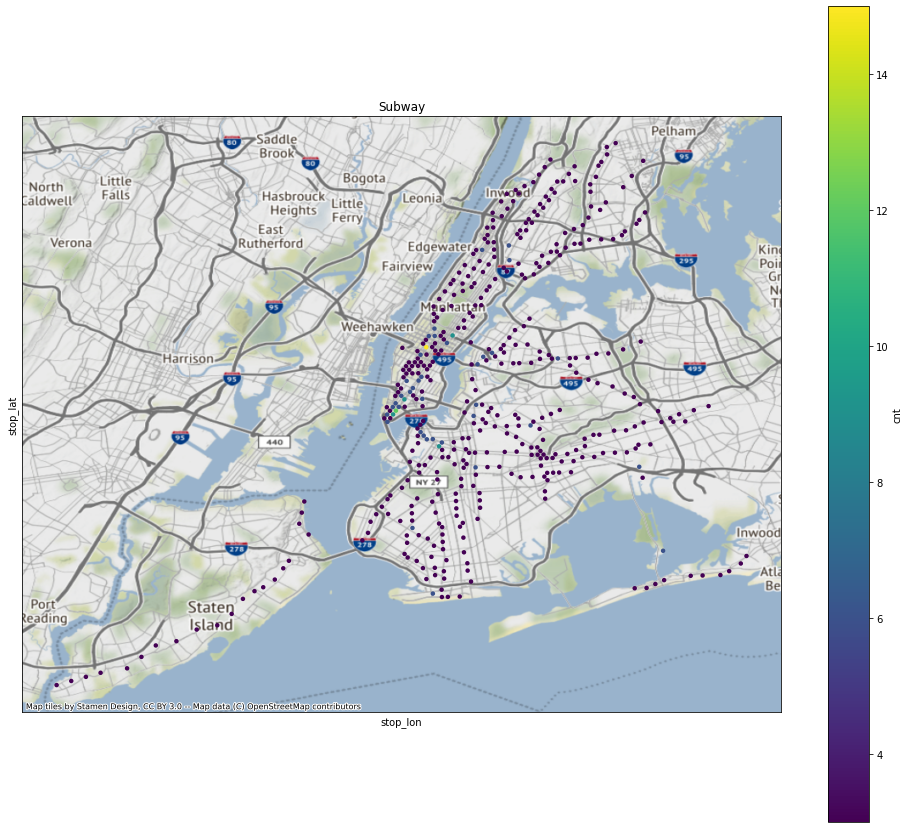

In [20]:
# pltot the hexs
plot_scatter(stopsg, metric_col='cnt', y="stop_lat", x="stop_lon", marker='o',figsize=(17,15), basemap=combined.crs.to_string())
plt.title('Subway')

In [21]:
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['stop_lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['stop_lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

sum sanity check: 1.0


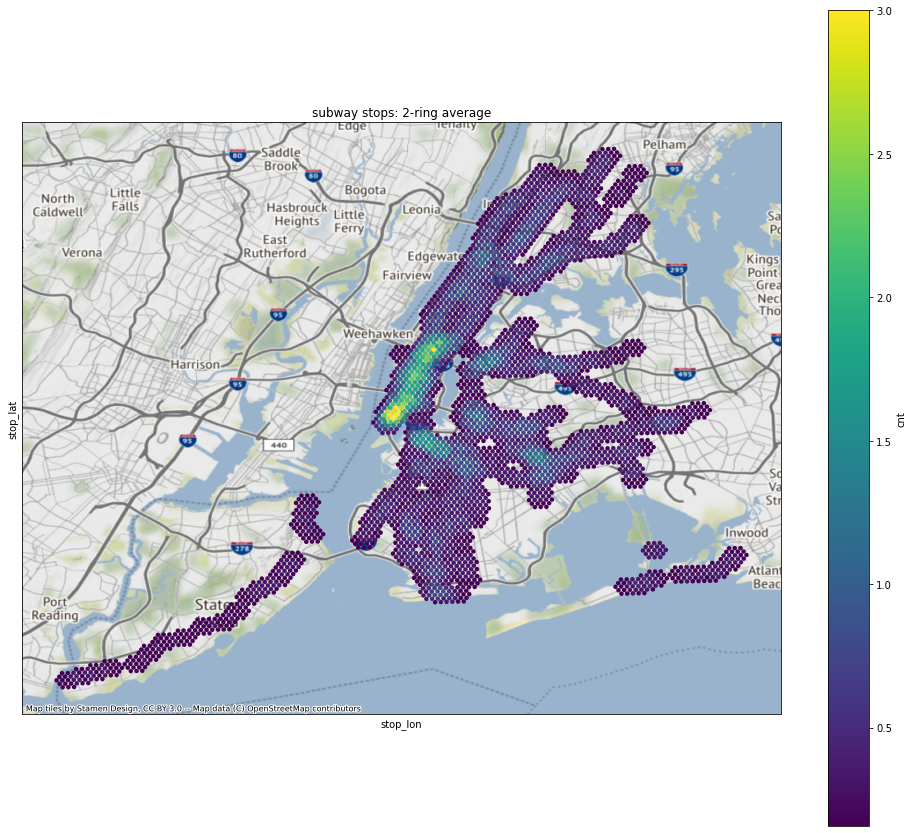

In [22]:
#kring_smoothing
k = 2
stops_kring= kring_smoothing(stopsg, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', stops_kring['cnt'].sum() / stopsg['cnt'].sum())

fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
stops_kring.plot.scatter(ax=ax, x='stop_lon', y='stop_lat', c='cnt',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway stops: 2-ring average');

ctx.add_basemap(ax=ax, crs="EPSG:4326")

In [23]:
stops_kring

hex9       cnt   stop_lat   stop_lon
0     892a100024fffff  0.157895  40.857328 -73.824784
1     892a1000263ffff  0.157895  40.852149 -73.820309
2     892a100026bffff  0.157895  40.852039 -73.824594
3     892a100026fffff  0.157895  40.849450 -73.822357
4     892a100027bffff  0.157895  40.854738 -73.822546
...               ...       ...        ...        ...
3368  892a10776a3ffff  0.157895  40.664876 -74.003763
3369  892a10776a7ffff  0.157895  40.662296 -74.001524
3370  892a10776afffff  0.157895  40.662180 -74.005792
3371  892a10776b3ffff  0.157895  40.667572 -74.001733
3372  892a10776b7ffff  0.315789  40.664992 -73.999494

[3373 rows x 4 columns]

In [24]:
stops_kring.describe()

cnt     stop_lat     stop_lon
count  3373.000000  3373.000000  3373.000000
mean      0.443819    40.711751   -73.941223
std       0.372201     0.096294     0.090029
min       0.157895    40.507331   -74.259713
25%       0.157895    40.639996   -73.982692
50%       0.315789    40.703090   -73.939739
75%       0.473684    40.784207   -73.880673
max       3.000000    40.907095   -73.747545

# Census to Hex
https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb

In [25]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()
gdf = gdf.to_crs("EPSG:4326")
METRIC_COL = 'Workers 16 Years and Over: Public Transportation (Includes Taxicab)'
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


Text(0.5, 1.0, 'census tract: comutetime')

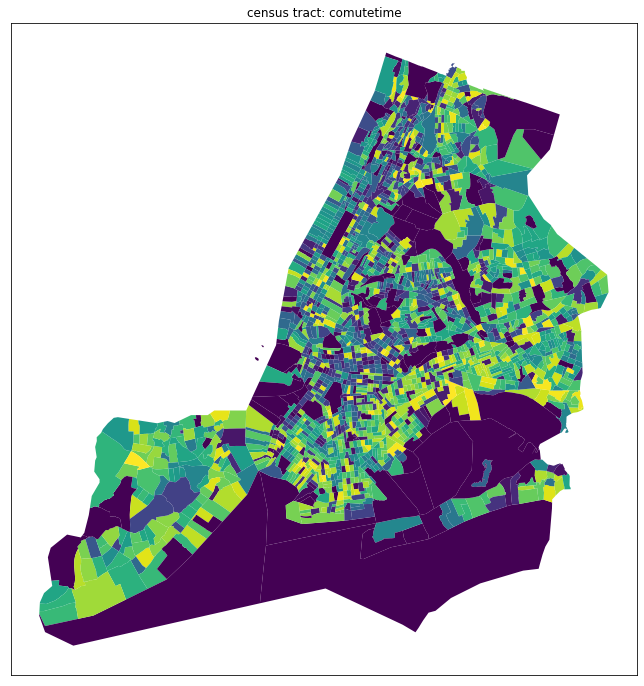

In [26]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: comutetime')

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


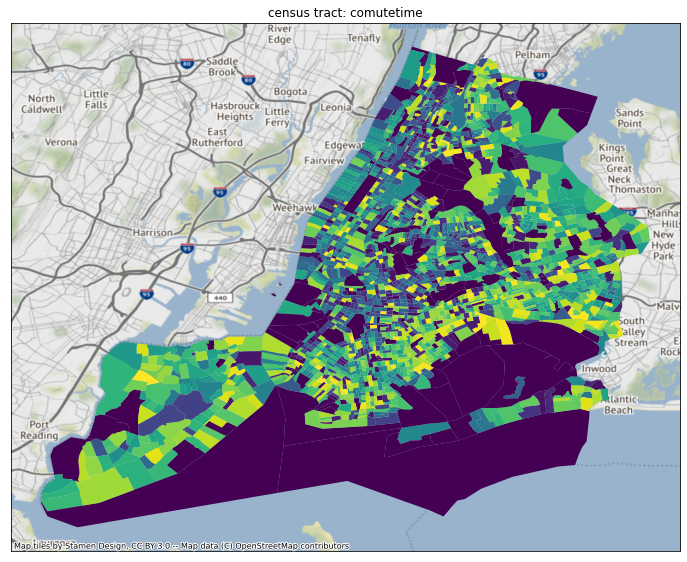

In [27]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: comutetime')
ctx.add_basemap(ax=ax, crs=gdf.crs)

In [28]:
# Unify the CT boundries
union_poly = gdf.geometry.unary_union

In [29]:
APERTURE_SIZE = 9

In [30]:
# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
    print(n,'\r')
    temp  = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,APERTURE_SIZE))

0 
1 
2 


/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_14702/2716173586.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for n,g in enumerate(union_poly):


In [31]:
# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

Sanity Check
number of hexes: 11565
number of duplicates: 0


In [32]:
# add lat & lng of center of hex 
dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [33]:
# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)


/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [34]:
dfh.crs = {"init": "EPSG:4326"}

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_14702/3066430071.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfh.crs = {"init": "EPSG:4326"}


/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_14702/2662139995.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  df_ct = gpd.tools.sjoin(gdf, dfh, how="inner")


STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  \
2785      36      085  019800  36085019800     198     Census Tract 198   
4174      36      047  070203  36047070203  702.03  Census Tract 702.03   
5269      36      081  097300  36081097300     973     Census Tract 973   

      MTFCC FUNCSTAT    ALAND    AWATER  ...  \
2785  G5020        S  5586388   4546063  ...   
4174  G5020        S  2814173  19419444  ...   
5269  G5020        S   528721    191606  ...   

     Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes  \
2785                                                704                  
4174                                                  0                  
5269                                                116                  

     Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes  \
2785                                                582                  
4174                                                  0                  
5269                                                121                  

     Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes  \
2785                                                696                  
4174                                                  0                  
5269                                                202                  

     Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes  \
2785                                                438                    
4174                                                  0                    
5269                                                 76                    

     Workers 16 Years and Over: Worked At Home.1  \
2785                                         228   
4174                                           0   
5269                                          64   

     Average Commute to Work (In Min) index_right             hex9        lat  \
2785                               47        6788  892a106e497ffff  40.519359   
4174                              NaN        8052  892a1039063ffff  40.610716   
5269                               41       10026  892a1001937ffff  40.793993   

            lng  
2785 -74.204634  
4174 -73.856527  
5269 -73.818235  

[3 rows x 92 columns]

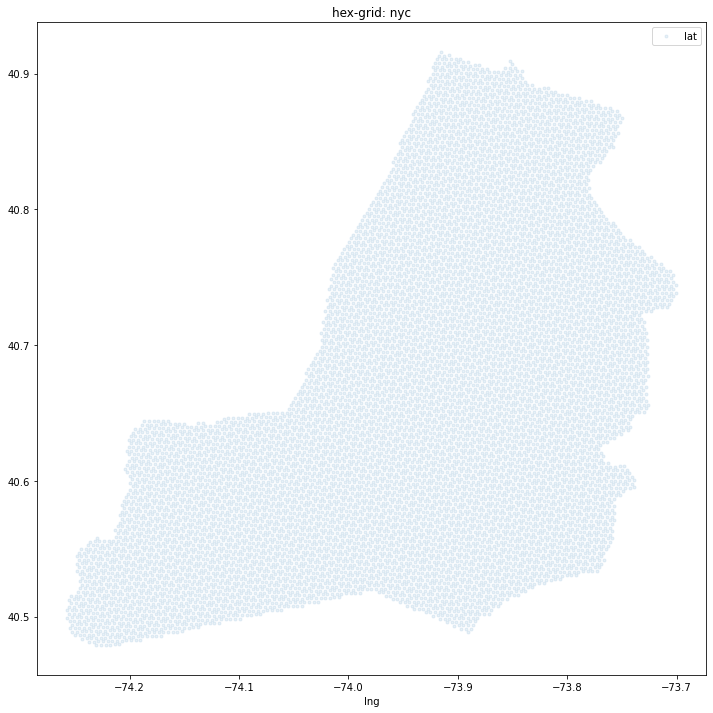

In [35]:
# plot hex latlng
dfh.plot(x='lng',y='lat',style='.',alpha=.1,figsize=(12,12));
plt.title('hex-grid: nyc')
dfh = GeoDataFrame(dfh)
# Intersect Hex Point with CT Polygon
df_ct = gpd.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)


In [36]:
df_ct[METRIC_COL] = df_ct[METRIC_COL].astype(int)

<AxesSubplot:title={'center':'Workers 16 Years and Over: Public Transportation (Includes Taxicab)'}, xlabel='lng', ylabel='lat'>

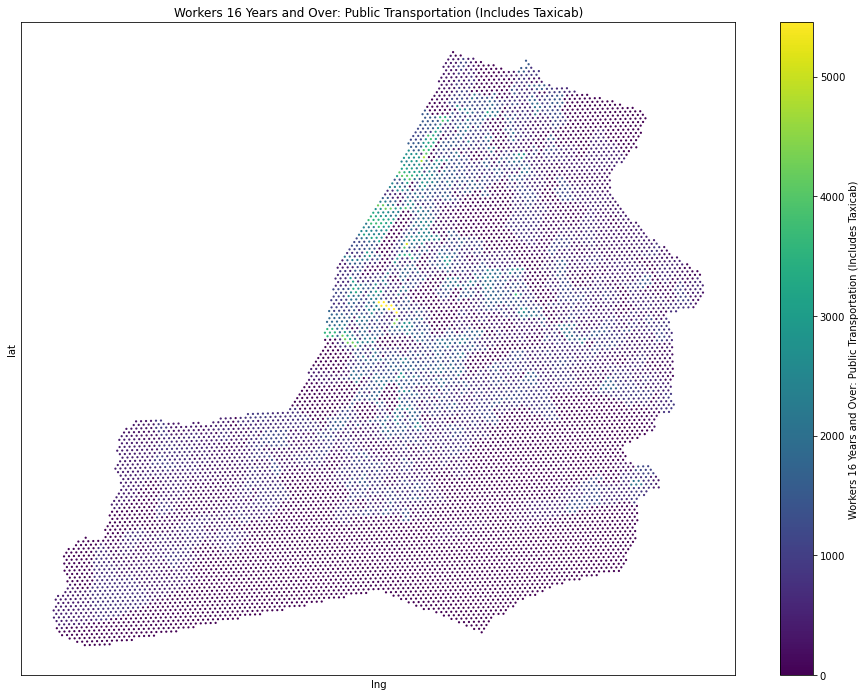

In [37]:
plot_scatter(pd.DataFrame(df_ct), metric_col=METRIC_COL, marker='.')

# Spatial weight smoothing

In [38]:
def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

In [39]:
def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc


Text(0, 0.5, 'Smoothing Coef')

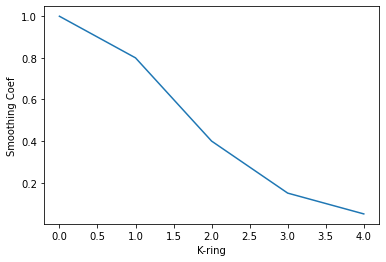

In [40]:
# kring smoothing coefficients
coef = [1, .8, .4, .15, 0.05]
plt.plot(coef)
plt.xlabel('K-ring')
plt.ylabel('Smoothing Coef')

In [41]:
# weighted kring smoothing
df_ct_kw = weighted_kring_smoothing(df_ct, hex_col, metric_col=METRIC_COL, coef=coef)

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_14702/360021348.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['hexk'] = df_agg[hex_col]


In [42]:
print('sum sanity check:', df_ct_kw[METRIC_COL].sum() / df_ct[METRIC_COL].sum())

sum sanity check: 1.0000000000000002


Text(0.5, 1.0, 'hex-grid: smoothed comute time')

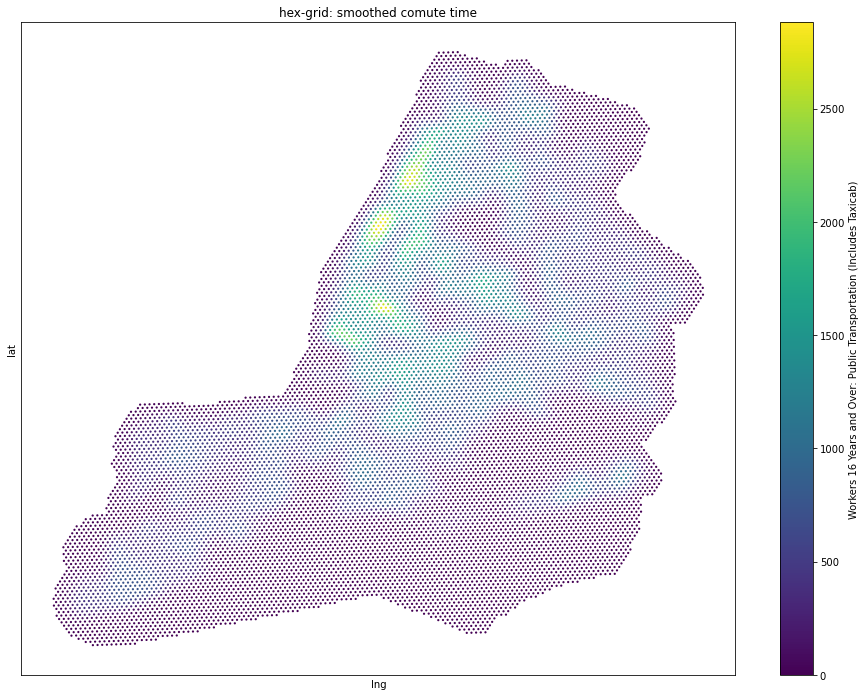

In [43]:
plot_scatter(df_ct_kw, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: smoothed comute time')

In [44]:
# Spatial Hierarchy using h3_to_parent
coarse_aperture_size = 9
df_coarse = aperture_downsampling(df_ct_kw, hex_col, metric_col=METRIC_COL, coarse_aperture_size=coarse_aperture_size)
print('number of hex:', len(df_ct_kw))
print('number of coarse hex:', len(df_coarse))

number of hex: 13760
number of coarse hex: 13760


In [45]:
df_coarse

hex9  \
0      892a1000003ffff   
1      892a1000007ffff   
2      892a100000bffff   
3      892a100000fffff   
4      892a1000013ffff   
...                ...   
13755  892a10776cbffff   
13756  892a10776cfffff   
13757  892a10776d3ffff   
13758  892a10776d7ffff   
13759  892a10776dbffff   

       Workers 16 Years and Over: Public Transportation (Includes Taxicab)  \
0                                             108.800000                     
1                                             112.551724                     
2                                             176.331034                     
3                                             211.972414                     
4                                              39.393103                     
...                                                  ...                     
13755                                         280.800000                     
13756                                         221.255172                     
13757                                         300.337931                     
13758                                         352.600000                     
13759                                         272.006897                     

             lat        lng  
0      40.858416 -73.781928  
1      40.855826 -73.779693  
2      40.858308 -73.786214  
3      40.855718 -73.783978  
4      40.861115 -73.779877  
...          ...        ...  
13755  40.674963 -74.021257  
13756  40.672383 -74.019017  
13757  40.677777 -74.014958  
13758  40.675197 -74.012718  
13759  40.677660 -74.019227  

[13760 rows x 4 columns]

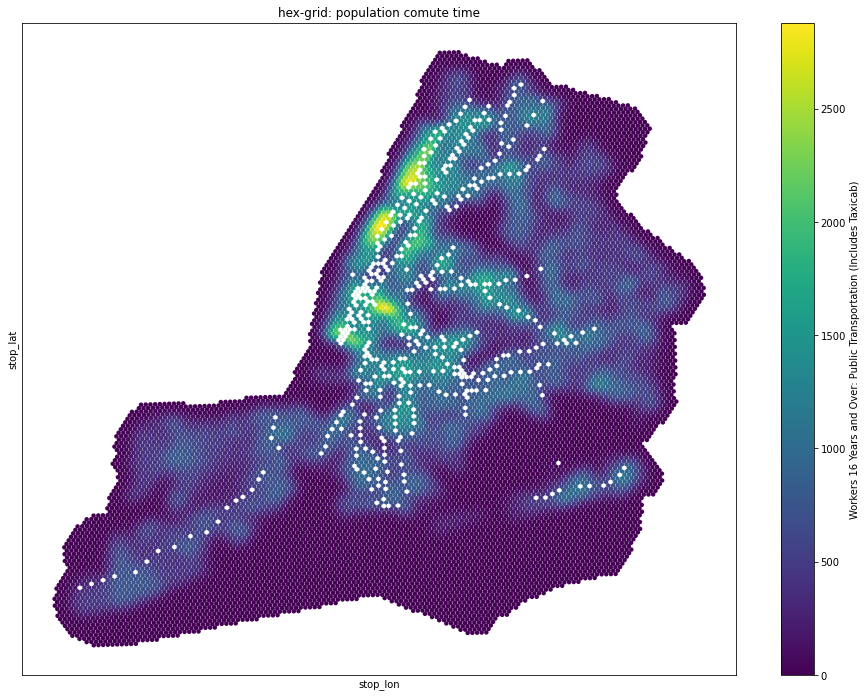

In [46]:
ax = plot_scatter(df_coarse, metric_col=METRIC_COL, marker='o')
stopsg.plot.scatter(ax=ax, y="stop_lat",c="white", x="stop_lon", marker='o',edgecolors='none')
plt.title('hex-grid: population comute time');

## Unifying data layers

Workers 16 Years and Over: Public Transportation (Includes Taxicab)  \
count                                         447.000000                     
mean                                         1093.926822                     
std                                           478.855257                     
min                                            53.400000                     
25%                                           712.737931                     
50%                                          1039.896552                     
75%                                          1368.729310                     
max                                          2811.751724                     

             stop  
count  447.000000  
mean     3.348993  
std      1.204957  
min      3.000000  
25%      3.000000  
50%      3.000000  
75%      3.000000  
max     15.000000

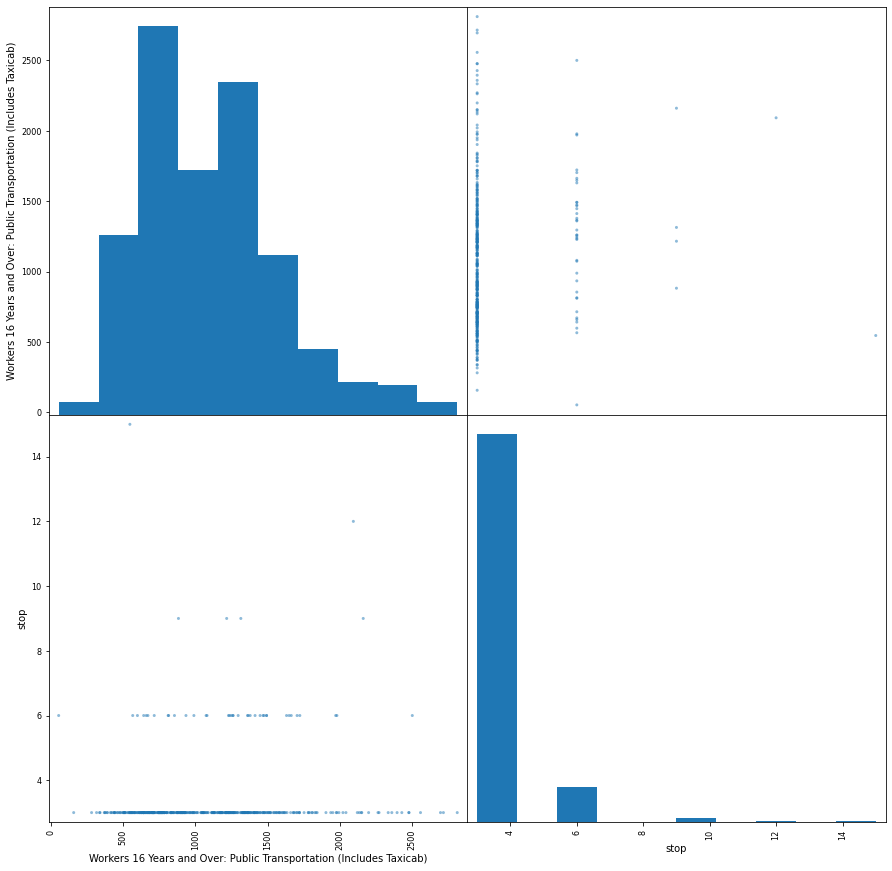

In [47]:
dfu = df_coarse[[METRIC_COL,hex_col]].merge(stopsg[[hex_col,'cnt']].rename(columns={"cnt":"stop"}))
dfu.set_index(hex_col,inplace=True)
pd.plotting.scatter_matrix(dfu, alpha=0.5,figsize=(15,15));
# dfu['lat']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[0])
# dfu['lng']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[1])
dfu.describe()

# Morans I Analysis

In [48]:
import esda
from pysal.lib import weights
import seaborn as sns
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights

In [49]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()
gdf = gdf.to_crs("EPSG:4326")
METRIC_COL = 'Workers 16 Years and Over: Public Transportation (Includes Taxicab)'
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

In [ ]:
gdf

In [50]:
gdf[METRIC_COL] = gdf[METRIC_COL].astype(float)

In [51]:
sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf[["Workers 16 Years and Over: Public Transportation (Includes Taxicab)", "GEOID", "geometry"]], how="right", predicate='intersects')

In [52]:
sgdf.head(2)

hex9  cnt   stop_lat   stop_lon                    geometry
0  892a1001057ffff    3  40.877494 -73.864129  POINT (-73.86413 40.87749)
1  892a100106fffff    3  40.866803 -73.868027  POINT (-73.86803 40.86680)

In [53]:
gdf.head(2)

index_left  cnt  \
0         NaN  NaN   
1       344.0  3.0   

   Workers 16 Years and Over: Public Transportation (Includes Taxicab)  \
0                                             1471.0                     
1                                             2112.0                     

         GEOID                                           geometry  
0  36047000700  POLYGON ((-74.00154 40.69279, -74.00132 40.693...  
1  36047000900  POLYGON ((-73.99405 40.69090, -73.99374 40.691...

In [54]:
gdf = gdf.merge(gdf.groupby("GEOID").cnt.sum(), on="GEOID")
gdf = gdf[["GEOID", "geometry", "Workers 16 Years and Over: Public Transportation (Includes Taxicab)", "cnt_y"]].rename(columns={"cnt_y":"Total_num_stops"}).drop_duplicates()

In [55]:
gdf.head()

GEOID                                           geometry  \
0  36047000700  POLYGON ((-74.00154 40.69279, -74.00132 40.693...   
1  36047000900  POLYGON ((-73.99405 40.69090, -73.99374 40.691...   
2  36047001100  POLYGON ((-73.99073 40.69305, -73.99045 40.693...   
4  36047001300  POLYGON ((-73.99141 40.69863, -73.99131 40.699...   
5  36047002000  POLYGON ((-74.01867 40.64741, -74.01809 40.647...   

   Workers 16 Years and Over: Public Transportation (Includes Taxicab)  \
0                                             1471.0                     
1                                             2112.0                     
2                                              795.0                     
4                                              481.0                     
5                                              332.0                     

   Total_num_stops  
0              0.0  
1              3.0  
2             12.0  
4              3.0  
5              0.0

In [56]:
w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 36061000100.
  warnings.warn(message)


<AxesSubplot:>

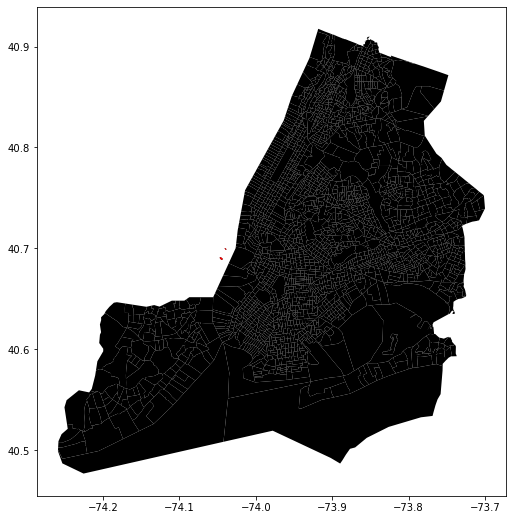

In [57]:
ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)

In [58]:
gdf = gdf.loc[~gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [59]:
%time w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

CPU times: user 449 ms, sys: 4.24 ms, total: 453 ms
Wall time: 454 ms


In [60]:
# Row standardize the matrix
w.transform = 'R'

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)


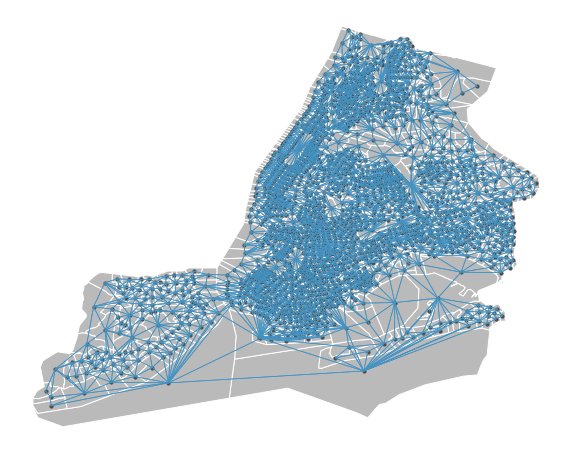

In [61]:
plot_spatial_weights(w, gdf.to_crs(epsg=4326), indexed_on="GEOID"); # Use the British National Grid, 27700

In [62]:
gdf['w_avg_com'] = weights.lag_spatial(w, gdf['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'])
gdf['w_Total_num_stops'] = weights.lag_spatial(w, gdf['Total_num_stops'])

In [63]:
gdf['Total_num_stops_std'] = (
    gdf['Total_num_stops'] - gdf['Total_num_stops'].mean()
) / gdf['Total_num_stops'].std()

In [64]:
gdf['avg_com_std'] = (
    gdf['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'] - gdf['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'].mean()
) / gdf['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'].std()

In [65]:
gdf.head()

GEOID                                           geometry  \
0  36047000700  POLYGON ((-74.00154 40.69279, -74.00132 40.693...   
1  36047000900  POLYGON ((-73.99405 40.69090, -73.99374 40.691...   
2  36047001100  POLYGON ((-73.99073 40.69305, -73.99045 40.693...   
3  36047001300  POLYGON ((-73.99141 40.69863, -73.99131 40.699...   
4  36047002000  POLYGON ((-74.01867 40.64741, -74.01809 40.647...   

   Workers 16 Years and Over: Public Transportation (Includes Taxicab)  \
0                                             1471.0                     
1                                             2112.0                     
2                                              795.0                     
3                                              481.0                     
4                                              332.0                     

   Total_num_stops    w_avg_com  w_Total_num_stops  Total_num_stops_std  \
0              0.0  1024.000000           0.000000             -0.39554   
1              3.0   976.714286           3.000000              1.44820   
2             12.0   905.285714           1.285714              6.97942   
3              3.0   875.428571           3.000000              1.44820   
4              0.0   939.571429           0.428571             -0.39554   

   avg_com_std  
0     0.818360  
1     1.752955  
2    -0.167266  
3    -0.625086  
4    -0.842332

In [66]:
gdf['w_avg_com_std'] = weights.lag_spatial(w, gdf['avg_com_std'])

In [67]:
gdf['w_Total_num_stops_std'] = weights.lag_spatial(w, gdf['Total_num_stops_std'])

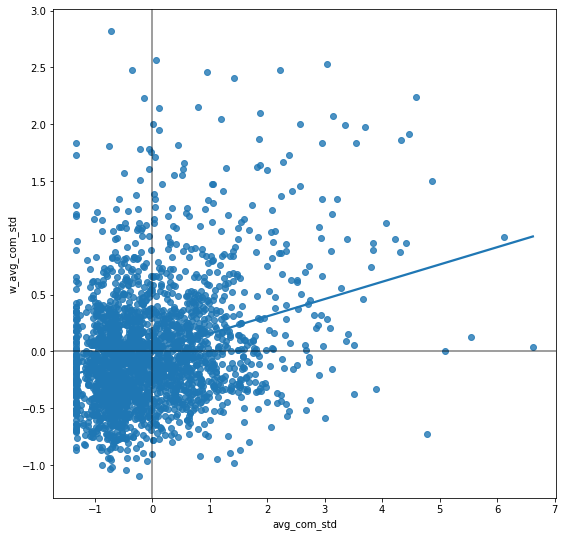

In [68]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='avg_com_std', y='w_avg_com_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

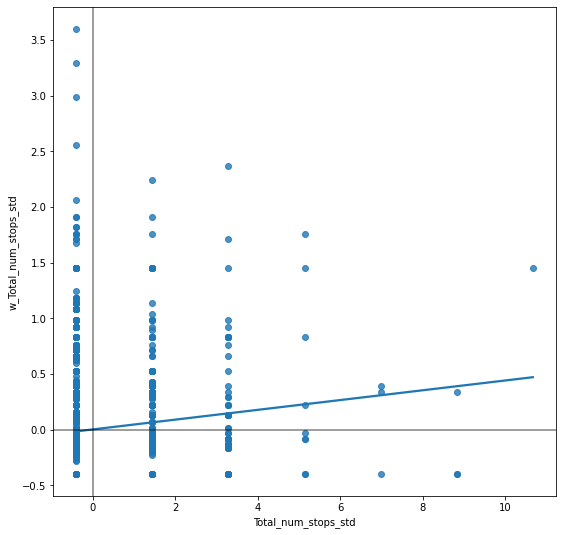

In [69]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Total_num_stops_std', y='w_Total_num_stops_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [70]:
mi = esda.Moran(gdf["Workers 16 Years and Over: Public Transportation (Includes Taxicab)"], w)
mi.I, mi.p_sim

(0.15200275760251059, 0.001)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.15)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

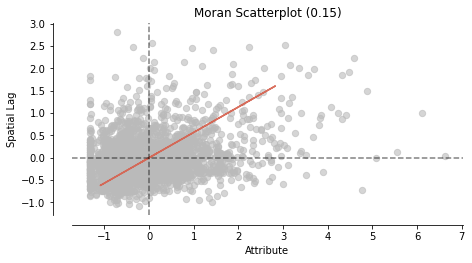

In [71]:
moran_scatterplot(mi)

In [72]:
mi = esda.Moran(gdf["Total_num_stops"], w)
mi.I, mi.p_sim

(0.043984303191008635, 0.001)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.04)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

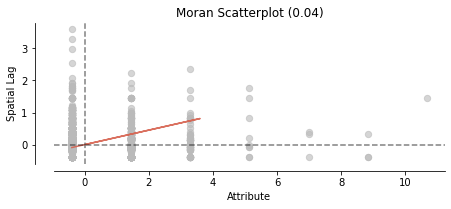

In [73]:
moran_scatterplot(mi)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.04', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.04)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

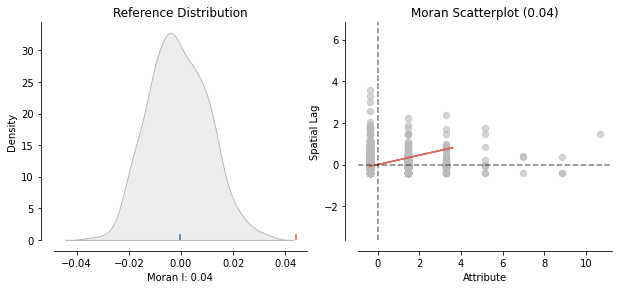

In [74]:
plot_moran(mi)

In [75]:
lisa = esda.Moran_Local(gdf["Workers 16 Years and Over: Public Transportation (Includes Taxicab)"], w)

In [76]:
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

In [77]:
gdf['significant'].head()

0    False
1    False
2    False
3    False
4    False
Name: significant, dtype: bool

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

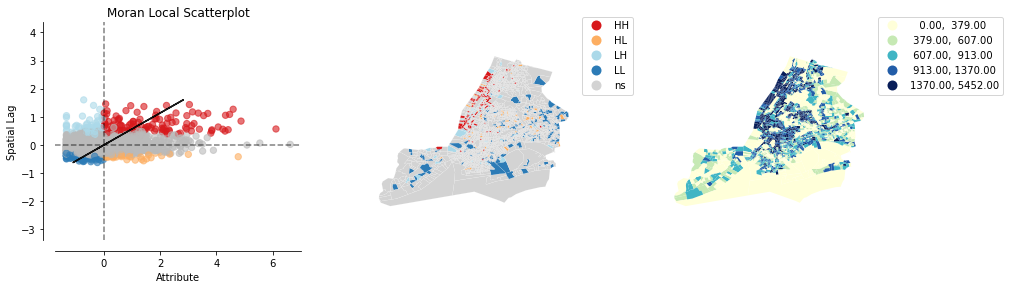

In [78]:
plot_local_autocorrelation(lisa, gdf, "Workers 16 Years and Over: Public Transportation (Includes Taxicab)")

In [79]:
lisa = esda.Moran_Local(gdf["Total_num_stops"], w)

In [80]:
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

In [81]:
gdf['significant'].head()

0    False
1     True
2    False
3     True
4    False
Name: significant, dtype: bool

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

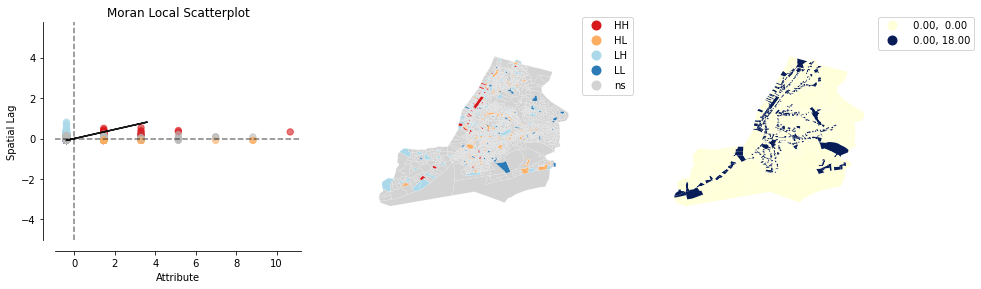

In [82]:
plot_local_autocorrelation(lisa, gdf, "Total_num_stops")

In [ ]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()
gdf = gdf.to_crs("EPSG:4326")
METRIC_COL = 'Average Commute to Work (In Min)'
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

In [ ]:
gdf[METRIC_COL] = gdf[METRIC_COL].astype(float)

In [ ]:
sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf[["Average Commute to Work (In Min)", "GEOID", "geometry"]], how="right", predicate='intersects')

In [ ]:
sgdf.head(2)

In [ ]:
gdf.head(2)

In [ ]:
gdf = gdf.merge(gdf.groupby("GEOID").cnt.sum(), on="GEOID")
gdf = gdf[["GEOID", "geometry", "Average Commute to Work (In Min)", "cnt_y"]].rename(columns={"cnt_y":"Total_num_stops"}).drop_duplicates()

In [ ]:
gdf.head()

In [ ]:
w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

In [ ]:
ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)

In [ ]:
gdf = gdf.loc[~gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [ ]:
%time w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

In [ ]:
# Row standardize the matrix
w.transform = 'R'

In [ ]:
plot_spatial_weights(w, gdf.to_crs(epsg=4326), indexed_on="GEOID"); # Use the British National Grid, 27700

In [ ]:
gdf['w_avg_com'] = weights.lag_spatial(w, gdf['Average Commute to Work (In Min)'])
gdf['w_Total_num_stops'] = weights.lag_spatial(w, gdf['Total_num_stops'])

In [ ]:
gdf['Total_num_stops_std'] = (
    gdf['Total_num_stops'] - gdf['Total_num_stops'].mean()
) / gdf['Total_num_stops'].std()

In [ ]:
gdf['avg_com_std'] = (
    gdf['Average Commute to Work (In Min)'] - gdf['Average Commute to Work (In Min)'].mean()
) / gdf['Average Commute to Work (In Min)'].std()

In [ ]:
gdf.head()

In [ ]:
gdf['w_avg_com_std'] = weights.lag_spatial(w, gdf['avg_com_std'])

In [ ]:
gdf['w_Total_num_stops_std'] = weights.lag_spatial(w, gdf['Total_num_stops_std'])

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='avg_com_std', y='w_avg_com_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Total_num_stops_std', y='w_Total_num_stops_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [ ]:
mi = esda.Moran(gdf["Average Commute to Work (In Min)"], w)
mi.I, mi.p_sim

In [ ]:
moran_scatterplot(mi)

In [ ]:
mi = esda.Moran(gdf["Total_num_stops"], w)
mi.I, mi.p_sim

In [ ]:
moran_scatterplot(mi)

In [ ]:
plot_moran(mi)

In [ ]:
lisa = esda.Moran_Local(gdf["Average Commute to Work (In Min)"], w)

In [ ]:
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

In [ ]:
gdf['significant'].head()

In [ ]:
plot_local_autocorrelation(lisa, gdf, "Average Commute to Work (In Min)")

In [ ]:
lisa = esda.Moran_Local(gdf["Total_num_stops"], w)

In [ ]:
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

In [ ]:
gdf['significant'].head()

In [ ]:
plot_local_autocorrelation(lisa, gdf, "Total_num_stops")

In [ ]:
gdf = combined.loc[combined.COUNTYFP.isin(["081"])].copy()
gdf = gdf.to_crs("EPSG:4326")
METRIC_COL = 'Average Commute to Work (In Min)'
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

gdf[METRIC_COL] = gdf[METRIC_COL].astype(float)

sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf[["Average Commute to Work (In Min)", "GEOID", "geometry"]], how="right", predicate='intersects')


gdf = gdf.merge(gdf.groupby("GEOID").cnt.sum(), on="GEOID")
gdf = gdf[["GEOID", "geometry", "Average Commute to Work (In Min)", "cnt_y"]].rename(columns={"cnt_y":"Total_num_stops"}).drop_duplicates()


w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)

gdf = gdf.loc[~gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

# Row standardize the matrix
w.transform = 'R'

plot_spatial_weights(w, gdf.to_crs(epsg=4326), indexed_on="GEOID"); # Use the British National Grid, 27700

gdf['w_avg_com'] = weights.lag_spatial(w, gdf['Average Commute to Work (In Min)'])
gdf['w_Total_num_stops'] = weights.lag_spatial(w, gdf['Total_num_stops'])

gdf['Total_num_stops_std'] = (
    gdf['Total_num_stops'] - gdf['Total_num_stops'].mean()
) / gdf['Total_num_stops'].std()

gdf['avg_com_std'] = (
    gdf['Average Commute to Work (In Min)'] - gdf['Average Commute to Work (In Min)'].mean()
) / gdf['Average Commute to Work (In Min)'].std()


gdf['w_avg_com_std'] = weights.lag_spatial(w, gdf['avg_com_std'])

gdf['w_Total_num_stops_std'] = weights.lag_spatial(w, gdf['Total_num_stops_std'])

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='avg_com_std', y='w_avg_com_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Total_num_stops_std', y='w_Total_num_stops_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

mi = esda.Moran(gdf["Average Commute to Work (In Min)"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

mi = esda.Moran(gdf["Total_num_stops"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

plot_moran(mi)

lisa = esda.Moran_Local(gdf["Average Commute to Work (In Min)"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Average Commute to Work (In Min)")

lisa = esda.Moran_Local(gdf["Total_num_stops"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Total_num_stops")



In [ ]:
# gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()

gdf = combined.loc[combined.COUNTYFP.isin(["047"])].copy()
gdf = gdf.to_crs("EPSG:4326")
METRIC_COL = 'Average Commute to Work (In Min)'
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

gdf[METRIC_COL] = gdf[METRIC_COL].astype(float)

sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf[["Average Commute to Work (In Min)", "GEOID", "geometry"]], how="right", predicate='intersects')


gdf = gdf.merge(gdf.groupby("GEOID").cnt.sum(), on="GEOID")
gdf = gdf[["GEOID", "geometry", "Average Commute to Work (In Min)", "cnt_y"]].rename(columns={"cnt_y":"Total_num_stops"}).drop_duplicates()


w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)

gdf = gdf.loc[~gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

# Row standardize the matrix
w.transform = 'R'

plot_spatial_weights(w, gdf.to_crs(epsg=4326), indexed_on="GEOID"); # Use the British National Grid, 27700

gdf['w_avg_com'] = weights.lag_spatial(w, gdf['Average Commute to Work (In Min)'])
gdf['w_Total_num_stops'] = weights.lag_spatial(w, gdf['Total_num_stops'])

gdf['Total_num_stops_std'] = (
    gdf['Total_num_stops'] - gdf['Total_num_stops'].mean()
) / gdf['Total_num_stops'].std()

gdf['avg_com_std'] = (
    gdf['Average Commute to Work (In Min)'] - gdf['Average Commute to Work (In Min)'].mean()
) / gdf['Average Commute to Work (In Min)'].std()


gdf['w_avg_com_std'] = weights.lag_spatial(w, gdf['avg_com_std'])

gdf['w_Total_num_stops_std'] = weights.lag_spatial(w, gdf['Total_num_stops_std'])

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='avg_com_std', y='w_avg_com_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Total_num_stops_std', y='w_Total_num_stops_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

mi = esda.Moran(gdf["Average Commute to Work (In Min)"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

mi = esda.Moran(gdf["Total_num_stops"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

plot_moran(mi)

lisa = esda.Moran_Local(gdf["Average Commute to Work (In Min)"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Average Commute to Work (In Min)")

lisa = esda.Moran_Local(gdf["Total_num_stops"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Total_num_stops")



In [ ]:
# gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()

gdf = combined.loc[combined.COUNTYFP.isin(["061"])].copy()
gdf = gdf.to_crs("EPSG:4326")
METRIC_COL = 'Average Commute to Work (In Min)'
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

gdf[METRIC_COL] = gdf[METRIC_COL].astype(float)

sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf[["Average Commute to Work (In Min)", "GEOID", "geometry"]], how="right", predicate='intersects')


gdf = gdf.merge(gdf.groupby("GEOID").cnt.sum(), on="GEOID")
gdf = gdf[["GEOID", "geometry", "Average Commute to Work (In Min)", "cnt_y"]].rename(columns={"cnt_y":"Total_num_stops"}).drop_duplicates()


w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)

gdf = gdf.loc[~gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

# Row standardize the matrix
w.transform = 'R'

plot_spatial_weights(w, gdf.to_crs(epsg=4326), indexed_on="GEOID"); # Use the British National Grid, 27700

gdf['w_avg_com'] = weights.lag_spatial(w, gdf['Average Commute to Work (In Min)'])
gdf['w_Total_num_stops'] = weights.lag_spatial(w, gdf['Total_num_stops'])

gdf['Total_num_stops_std'] = (
    gdf['Total_num_stops'] - gdf['Total_num_stops'].mean()
) / gdf['Total_num_stops'].std()

gdf['avg_com_std'] = (
    gdf['Average Commute to Work (In Min)'] - gdf['Average Commute to Work (In Min)'].mean()
) / gdf['Average Commute to Work (In Min)'].std()


gdf['w_avg_com_std'] = weights.lag_spatial(w, gdf['avg_com_std'])

gdf['w_Total_num_stops_std'] = weights.lag_spatial(w, gdf['Total_num_stops_std'])

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='avg_com_std', y='w_avg_com_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Total_num_stops_std', y='w_Total_num_stops_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

mi = esda.Moran(gdf["Average Commute to Work (In Min)"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

mi = esda.Moran(gdf["Total_num_stops"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

plot_moran(mi)

lisa = esda.Moran_Local(gdf["Average Commute to Work (In Min)"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Average Commute to Work (In Min)")

lisa = esda.Moran_Local(gdf["Total_num_stops"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Total_num_stops")



In [ ]:
# gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()

gdf = combined.loc[combined.COUNTYFP.isin(["085"])].copy()
gdf = gdf.to_crs("EPSG:4326")
METRIC_COL = 'Average Commute to Work (In Min)'
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

gdf[METRIC_COL] = gdf[METRIC_COL].astype(float)

sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf[["Average Commute to Work (In Min)", "GEOID", "geometry"]], how="right", predicate='intersects')


gdf = gdf.merge(gdf.groupby("GEOID").cnt.sum(), on="GEOID")
gdf = gdf[["GEOID", "geometry", "Average Commute to Work (In Min)", "cnt_y"]].rename(columns={"cnt_y":"Total_num_stops"}).drop_duplicates()


w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)

gdf = gdf.loc[~gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

w = weights.Queen.from_dataframe(gdf, idVariable="GEOID")

# Row standardize the matrix
w.transform = 'R'

plot_spatial_weights(w, gdf.to_crs(epsg=4326), indexed_on="GEOID"); # Use the British National Grid, 27700

gdf['w_avg_com'] = weights.lag_spatial(w, gdf['Average Commute to Work (In Min)'])
gdf['w_Total_num_stops'] = weights.lag_spatial(w, gdf['Total_num_stops'])

gdf['Total_num_stops_std'] = (
    gdf['Total_num_stops'] - gdf['Total_num_stops'].mean()
) / gdf['Total_num_stops'].std()

gdf['avg_com_std'] = (
    gdf['Average Commute to Work (In Min)'] - gdf['Average Commute to Work (In Min)'].mean()
) / gdf['Average Commute to Work (In Min)'].std()


gdf['w_avg_com_std'] = weights.lag_spatial(w, gdf['avg_com_std'])

gdf['w_Total_num_stops_std'] = weights.lag_spatial(w, gdf['Total_num_stops_std'])

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='avg_com_std', y='w_avg_com_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Total_num_stops_std', y='w_Total_num_stops_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

mi = esda.Moran(gdf["Average Commute to Work (In Min)"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

mi = esda.Moran(gdf["Total_num_stops"], w)
mi.I, mi.p_sim

moran_scatterplot(mi)

plot_moran(mi)

lisa = esda.Moran_Local(gdf["Average Commute to Work (In Min)"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Average Commute to Work (In Min)")

lisa = esda.Moran_Local(gdf["Total_num_stops"], w)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

gdf['significant'].head()

plot_local_autocorrelation(lisa, gdf, "Total_num_stops")



# Headline

How accessability effects how 

In [ ]:
stations nærhed princippet AAlborg bbb

In [83]:
https://vbn.aau.dk/ws/portalfiles/portal/285551436/Rapport_nr._3._By_og_Bane_Aalborg_Universitet.pdf

SyntaxError: invalid syntax (1050201173.py, line 1)

In [ ]:
- Peter: 
    - walking distance
    - Frequency
- Viktor: 
    - Point analysis
    - Trackt multivariate regression